In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset
Added /home/luky/skola/KalmanNet-main to sys.path


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device  # For backward compatibility
print(f"device: {device}")

device: cpu


/home/luky/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import Systems


# Parametry sekvencí
TRAIN_SEQ_LEN = 100       # Délka sekvence pro trénink (např. 100 kroků = 100 sekund při 1Hz)
VAL_SEQ_LEN = 250
TEST_SEQ_LEN = 1000      # Délka sekvence pro testování (delší sekvence pro stabilnější vyhodnocení)
STRIDE = 30         # Posun okna (překryv) pro data augmentation
BATCH_SIZE = 128
DATA_PATH = 'data/processed'
print(f"Běží na zařízení: {device}")

Běží na zařízení: cpu


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os

def prepare_sequences(dataset_list, seq_len, stride, mode='train'):
    """
    Zpracuje list trajektorií na sekvence pro trénink dle článku.
    
    Nový formát dle [Song et al., 2024]:
    - Vstup u (4D): [v_left, v_right, theta_imu, omega_imu]
    - Cíl x (6D):   [px, py, vx, vy, theta, omega]
    """
    X_seq_list = [] # Ground Truth (Cíl)
    Y_seq_list = [] # GPS Měření (Vstup do korekce)
    U_seq_list = [] # Control Input (IMU/Odo)
    
    print(f"Zpracovávám {len(dataset_list)} trajektorií pro {mode}...")
    
    for traj in dataset_list:
        # 1. Extrahuje data
        # GT z preprocessingu je [px, py, theta]
        gt = traj['ground_truth'].float() 
        
        # GPS: [x, y] (obsahuje NaN!)
        gps = traj['filtered_gps'].float()
        
        # IMU: [ax, ay, theta, omega]
        imu = traj['imu'].float()
        theta_imu = imu[:, 2] # Orientace z IMU
        omega_imu = imu[:, 3] # Úhlová rychlost z IMU
        
        # ODO: [v_left, v_right]
        odo = traj['filtered_wheel'].float()
        
        # Fix NaN v odometrii (nahradíme nulou)
        v_left = torch.nan_to_num(odo[:, 0], nan=0.0)
        v_right = torch.nan_to_num(odo[:, 1], nan=0.0)
        
        # 2. Sestavení vstupu u = [v_l, v_r, theta_imu, omega_imu] (4D)
        # Toto odpovídá "State Model" definovanému v článku (sekce II.C.2)
        u = torch.stack((v_left, v_right, theta_imu, omega_imu), dim=1)
        
        # 3. Sestavení cíle x (6D) pro state vector [px, py, vx, vy, theta, omega]
        # Vyplníme to, co máme z Ground Truth (px, py, theta).
        # Rychlosti (vx, vy, omega) v GT implicitně nemáme (nebo je složité je derivovat přesně),
        # ale pro trénink Loss funkce budeme stejně porovnávat primárně pozici.
        T = gt.shape[0]
        x_target = torch.zeros(T, 6)
        x_target[:, 0] = gt[:, 0] # px
        x_target[:, 1] = gt[:, 1] # py
        x_target[:, 4] = gt[:, 2] # theta
        # Ostatní (vx, vy, omega) zůstávají 0, protože v Loss funkci budeme maskovat nebo brát jen pozici.
        
        # 4. Sliding Window (Rozsekání na sekvence)
        num_samples = gt.shape[0]
        current_stride = stride if mode == 'train' else seq_len # U testu bez překryvu
        
        for i in range(0, num_samples - seq_len + 1, current_stride):
            # Cíl: 6D stav
            x_seq = x_target[i : i+seq_len, :]
            
            # Měření: GPS [px, py]
            y_seq = gps[i : i+seq_len, :]
            
            # Vstup: 4D control input
            u_seq = u[i : i+seq_len, :]
            
            X_seq_list.append(x_seq)
            Y_seq_list.append(y_seq)
            U_seq_list.append(u_seq)
            
    # Stack do tenzorů
    X_out = torch.stack(X_seq_list)
    Y_out = torch.stack(Y_seq_list)
    U_out = torch.stack(U_seq_list)
    
    return X_out, Y_out, U_out

# === NAČTENÍ DAT ===
# Ujistíme se, že cesty a konstanty jsou definované (pokud nejsou, doplňte je nahoře)
# if 'DATA_PATH' not in locals(): DATA_PATH = 'data/processed'
# if 'TRAIN_SEQ_LEN' not in locals(): TRAIN_SEQ_LEN = 100
# if 'VAL_SEQ_LEN' not in locals(): VAL_SEQ_LEN = 200
# if 'TEST_SEQ_LEN' not in locals(): TEST_SEQ_LEN = 500
# if 'STRIDE' not in locals(): STRIDE = 20
# if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 256

train_data_raw = torch.load(os.path.join(DATA_PATH, 'train.pt'))
val_data_raw = torch.load(os.path.join(DATA_PATH, 'val.pt'))
test_data_raw = torch.load(os.path.join(DATA_PATH, 'test.pt'))
# Načtení celého balíku
# train_data_full = torch.load(os.path.join(DATA_PATH, 'train.pt'))

# === RYCHLÝ TEST: OŘÍZNUTÍ DAT ===
# Vezmeme jen prvních 5 trajektorií z 22. 
# To radikálně zrychlí jednu epochu a umožní rychle otestovat stabilitu hyperparametrů.
# train_data_raw = train_data_full[:10] 

print(f"DEBUG: Pro rychlý test používám jen {len(train_data_raw)} trajektorií.")
# ... zbytek kódu beze změny

# === PŘÍPRAVA SEKVENCÍ ===
print("--- Generuji trénovací data (Paper compatible) ---")
train_X, train_Y, train_U = prepare_sequences(train_data_raw, TRAIN_SEQ_LEN, STRIDE, 'train')

print("\n--- Generuji validační data ---")
val_X, val_Y, val_U = prepare_sequences(val_data_raw, VAL_SEQ_LEN, VAL_SEQ_LEN, 'val')

print("\n--- Generuji testovací data ---")
test_X, test_Y, test_U = prepare_sequences(test_data_raw, TEST_SEQ_LEN, TEST_SEQ_LEN, 'test')

# Vytvoření DataLoaderů
train_loader = DataLoader(TensorDataset(train_X, train_Y, train_U), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_Y, val_U), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(test_X, test_Y, test_U), batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ Data připravena.")
print(f"Train batches: {len(train_loader)}")
print(f"Shapes -> X: {train_X.shape} (6D State), U: {train_U.shape} (4D Input), Y: {train_Y.shape} (2D Meas)")

DEBUG: Pro rychlý test používám jen 22 trajektorií.
--- Generuji trénovací data (Paper compatible) ---
Zpracovávám 22 trajektorií pro train...

--- Generuji validační data ---
Zpracovávám 2 trajektorií pro val...

--- Generuji testovací data ---
Zpracovávám 3 trajektorií pro test...

✅ Data připravena.
Train batches: 29
Shapes -> X: torch.Size([3635, 100, 6]) (6D State), U: torch.Size([3635, 100, 4]) (4D Input), Y: torch.Size([3635, 100, 2]) (2D Meas)


In [5]:
# === INICIALIZACE DYNAMICKÉHO MODELU (System Instance - Paper Version) ===

# 1. Parametry systému podle článku [Song et al., 2024]
# State (6D): [px, py, vx, vy, theta, omega]
# Referenční rovnice (5) v článku.
state_dim = 6
# Meas (2D):  [gps_x, gps_y]
# Referenční rovnice (6) v článku.
obs_dim = 2
# Časový krok (z preprocessingu)
dt = 1.0  

# 2. Definice Matice Q (Procesní šum / Model Uncertainty)
# Nyní máme 6 stavů. Musíme definovat nejistotu pro každý z nich.
# Hodnoty jsou nastaveny heuristicky (lze ladit):
# - Pozice (idx 0,1): 0.1
# - Rychlost (idx 2,3): 0.1
# - Úhel/Omega (idx 4,5): 0.01 (IMU je v NCLT docela přesné, ale driftuje)
q_diag = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])
Q = torch.diag(q_diag)

# 3. Definice Matice R (Šum měření / Sensor Noise)
# GPS měří jen pozici (px, py).
# Nastavujeme 1.0 m^2. To odpovídá standardní odchylce 1m.
# Pokud je GPS v datasetu horší, KalmanNet se naučí "nedůvěřovat" vstupu y
# a spoléhat více na predikci z u (odometrie).
r_diag = torch.tensor([1.0, 1.0])
R = torch.diag(r_diag)

# 4. Počáteční podmínky (Prior)
# Ex0: Nulový vektor 6x1
Ex0 = torch.zeros(state_dim, 1)

# P0: Počáteční kovariance
# Autoři používají P k inicializaci EKF[cite: 700].
# Nastavíme rozumnou počáteční nejistotu.
P0 = torch.eye(state_dim) * 0.5

# 5. Vytvoření instance DynamicSystemNCLT
# Důležité: f=None zajistí, že se použije interní `_f_paper_dynamics` (rovnice 5),
# která očekává 4D vstup (v_l, v_r, theta, omega).
sys_model = Systems.DynamicSystemNCLT(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q,
    R=R,
    Ex0=Ex0,
    P0=P0,
    dt=dt,
    f=None,  # None -> Použije se model z článku: px += vc*cos(theta_imu)...
    h=None,  # None -> Použije se GPS model: y = [px, py]
    device=DEVICE
)

print(f"✅ System Model NCLT inicializován (Paper Version).")
print(f" - State Dim: {sys_model.state_dim} [px, py, vx, vy, theta, omega]")
print(f" - Meas Dim:  {sys_model.obs_dim} [gps_x, gps_y]")
print(f" - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]") # Implicitně v modelu
print(f" - Q Diag: {q_diag.tolist()}")

✅ System Model NCLT inicializován (Paper Version).
 - State Dim: 6 [px, py, vx, vy, theta, omega]
 - Meas Dim:  2 [gps_x, gps_y]
 - Input Dim: 4 [v_l, v_r, theta_imu, omega_imu]
 - Q Diag: [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.009999999776482582, 0.009999999776482582]


In [ ]:
import torch
import torch.optim as optim
import os
from state_NN_models import NCLT
from utils import trainer

state_knet = NCLT.StateBayesianKalmanNetNCLT_test(
    system_model=sys_model,
    device=DEVICE,
    hidden_size_multiplier=10,      # Větší kapacita pro složitější dynamiku
    output_layer_multiplier=4,
    num_gru_layers=1,               # 1 vrstva GRU obvykle stačí a je stabilnější
    init_min_dropout=0.4,
    init_max_dropout=0.6
).to(DEVICE)
print(state_knet)

# Počet trénovatelných parametrů
params_count = sum(p.numel() for p in state_knet.parameters() if p.requires_grad)
print(f"Model má {params_count} trénovatelných parametrů.")
# === 3. PŘÍPRAVA A SPUŠTĚNÍ TRÉNINKU ===
print("\n🚀 Spouštím tréninkovou smyčku (Vektorizovanou)...")

# 1. Zjistíme velikost datasetu (počet batchů v jedné epoše)
num_train_batches = len(train_loader)
print(f"INFO: 1 Epocha = {num_train_batches} iterací (batchů).")

# 2. Nastavení parametrů
EPOCHS = 100
WARMUP_EPOCHS = 15  # Prvních 15 epoch jen MSE, aby se model stabilizoval

# Přepočet na iterace (protože nová funkce počítá v iteracích)
total_iterations = EPOCHS * num_train_batches
total_iterations = 800
warmup_iterations = WARMUP_EPOCHS * num_train_batches
warmup_iterations=150
validation_period = 5  # Chceme validovat jednou za epochu (na konci)

# 3. Volání funkce
trained_knet = trainer.train_BayesianKalmanNetNCLT_test(
    model=state_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    
    # Parametry iterací
    total_train_iter=total_iterations,
    learning_rate=5e-5,       # Opatrný LR pro BKN
    clip_grad=0.5,            # Stabilizace gradientů
    J_samples=10,              # Počet MC vzorků (paralelně)
    
    # Logování a validace
    validation_period=validation_period, 
    logging_period=1,        # Výpis loss každých 1 batchu
    
    # Warmup
    warmup_iterations=warmup_iterations,
    weight_decay_=1e-4,
    optimizer_type=torch.optim.AdamW
)

INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).
StateBayesianKalmanNetNCLT_test(
  (dnn): DNN_BayesianKalmanNetNCLT_test(
    (input_layer): Sequential(
      (0): Linear(in_features=16, out_features=640, bias=True)
      (1): ReLU()
    )
    (concrete_dropout1): ConcreteDropout()
    (gru): GRU(640, 160)
    (output_layer): Sequential(
      (0): Linear(in_features=160, out_features=48, bias=True)
      (1): ReLU()
      (2): Linear(in_features=48, out_features=12, bias=True)
    )
    (concrete_dropout2): ConcreteDropout()
  )
)
Model má 404158 trénovatelných parametrů.

🚀 Spouštím tréninkovou smyčku (Vektorizovanou)...
INFO: 1 Epocha = 29 iterací (batchů).

[DIAGNOSTIKA iter 0]
  -> Rozdíl (Pred - Target): 2.070566
  -> Min Variance v batchi:  0.00e+00
  -> Mean Variance v batchi: 1.61e-02
--- Iteration [1/800] ---
    - Total Loss: 19.4770
    - NLL: 35.3258
    - Reg: 0.3022
    - p1=0.569, p2=0.403

[DIAGNOSTIKA iter 1]
 

In [7]:
# import gc
# import torch

# # === GPU/CUDA Cleanup Helper (Models Only) ===
# # Frees GPU memory by moving neural nets to CPU, deleting their references,
# # forcing GC, and clearing CUDA cache. Does NOT remove DataLoaders or trainer.

# def _cuda_mem_info():
#     if torch.cuda.is_available():
#         alloc = torch.cuda.memory_allocated() / 1e6
#         reserv = torch.cuda.memory_reserved() / 1e6
#         print(f"CUDA mem -> Allocated: {alloc:.1f} MB | Reserved: {reserv:.1f} MB")
#     else:
#         print("CUDA not available.")

# print("Before cleanup:")
# _cuda_mem_info()

# # Release neural network models only
# for name in ["state_knet", "trained_model_bkn"]:
#     if name in globals():
#         obj = globals()[name]
#         try:
#             obj.to("cpu")
#         except Exception:
#             pass
#         # Drop common optimizer/scheduler refs if attached to the model
#         for attr in ["optimizer", "opt", "optim", "scheduler"]:
#             if hasattr(obj, attr):
#                 try:
#                     delattr(obj, attr)
#                 except Exception:
#                     pass
#         del globals()[name]
#         print(f"Released model '{name}' and deleted reference")

# # Force Python GC and clear CUDA cache
# gc.collect()
# if torch.cuda.is_available():
#     try:
#         torch.cuda.synchronize()
#     except Exception:
#         pass
#     torch.cuda.empty_cache()
#     try:
#         torch.cuda.ipc_collect()
#     except Exception:
#         pass

# print("After cleanup:")
# _cuda_mem_info()

In [8]:
if True:
    import torch
    import os

    # Protože jsi trénink přerušil, nemáme slovník s metrikami automaticky.
    # Musíme uložit přímo model 'state_knet'.

    # 1. Definuj cestu (Metriky si do názvu musíš dopsat ručně podle toho, co jsi viděl v logu naposledy,
    # nebo použij obecný název, abys o model nepřišel).
    save_path = 'best_BKN_test_results_legal.pth'
    # Pokud si pamatuješ hodnoty z logu (např. ANEES 23.5), můžeš je tam dopsat ručně:
    # save_path = 'best_kalmannet_nclt_sensor_fusion_ANEES23.57_MSE8.17_interrupted.pth'

    # 2. Uložení
    # DŮLEŽITÉ: Voláme .state_dict() přímo na objektu state_knet (nebo trained_knet, pokud jsi ho přiřadil)
    # Nepoužíváme závorky ['final_model'], protože state_knet UŽ JE ten model.
    torch.save(state_knet.state_dict(), save_path)

    print(f"\n✅ Záchrana modelu úspěšná! Uloženo do: {save_path}")

if False:
    import os
    trained_knet = state_knet 
    # Přístup k metrikám ve slovníku je správně (přes závorky [])
    print(f"   -> Best ANEES: {trained_knet['best_val_anees']:.4f}")
    print(f"   -> Best MSE:   {trained_knet['best_val_mse']:.4f}")
    save_path = f'best_kalmannet_nclt_sensor_fusion_ANEES{trained_knet["best_val_anees"]:.4f}_MSE{trained_knet["best_val_mse"]:.4f}_nejlepsi_test_vysledky.pth '

    # OPRAVA: Musíš vytáhnout model ze slovníku pomocí klíče 'final_model'
    # A teprve na něm zavolat .state_dict()
    torch.save(trained_knet['final_model'].state_dict(), save_path)

    print(f"\n✅ Model úspěšně uložen do: {save_path}")



✅ Záchrana modelu úspěšná! Uloženo do: best_BKN_test_results_legal.pth


INFO: Nastaveno sys_model.dt = 1.0 s
INFO: Používám Bayesian KalmanNet s J=50 vzorky.

Spouštím detailní evaluaci na 3 trajektoriích...

-----------------------------------------------------------------------------------------------
TRAJEKTORIE  | BKN MSE    | BKN ANEES  | EKF MSE    | EKF ANEES  | GPS MSE   
-----------------------------------------------------------------------------------------------
1            | 264.70     | 20.17      | 443.11     | 1027.02    | 164.46    


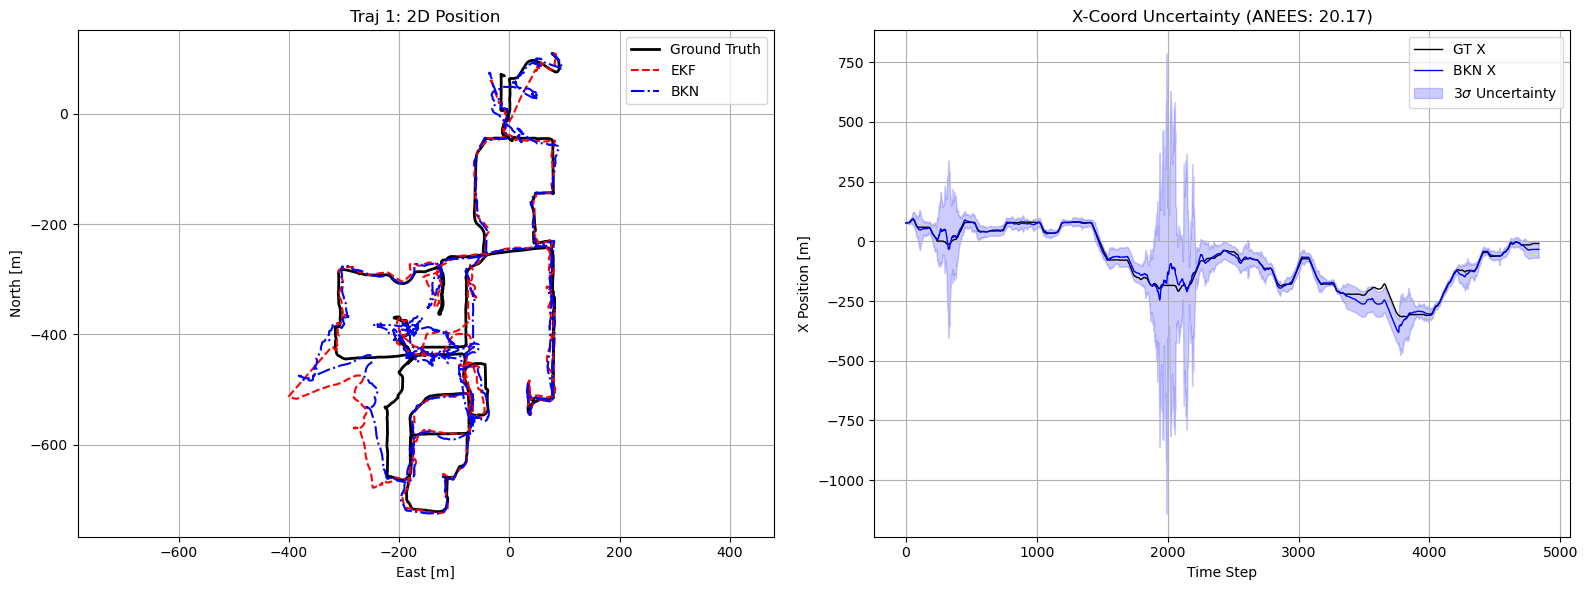

2            | 72.16      | 39.94      | 221.68     | 445.10     | 51.13     


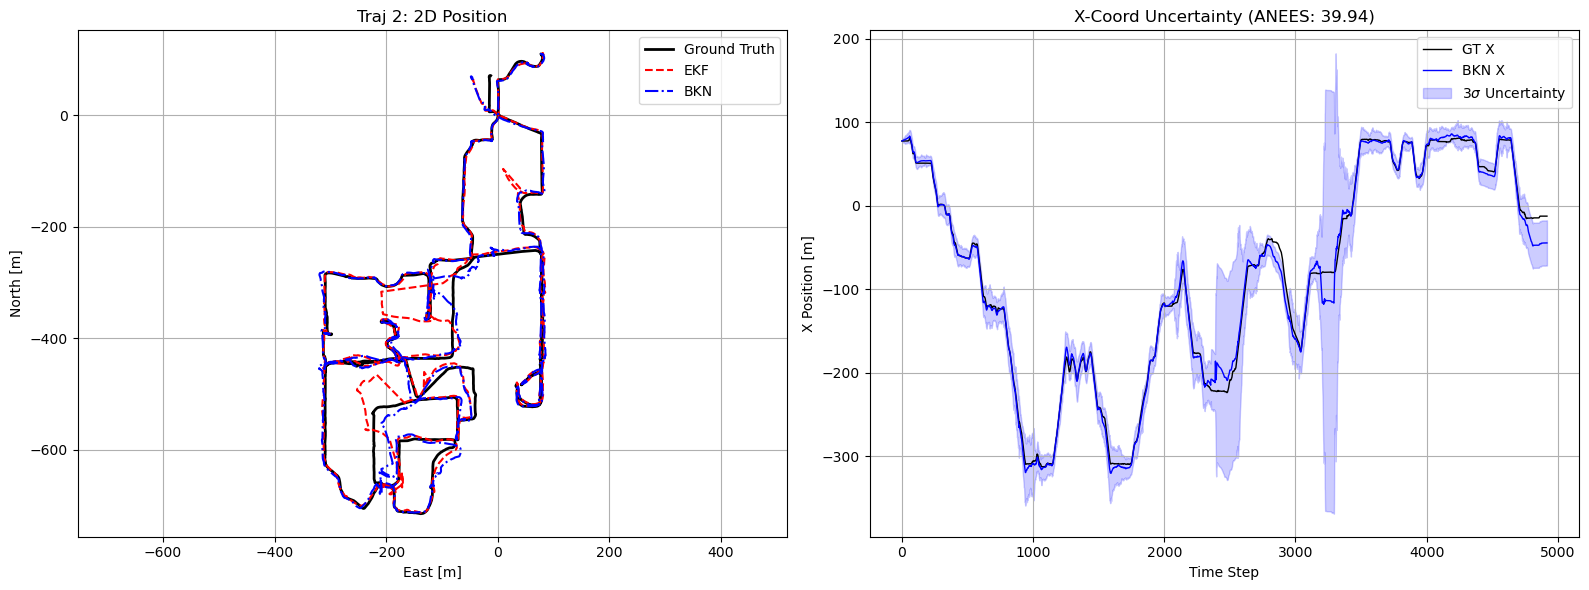

3            | 74.94      | 102.38     | 128.44     | 311.25     | 39.94     


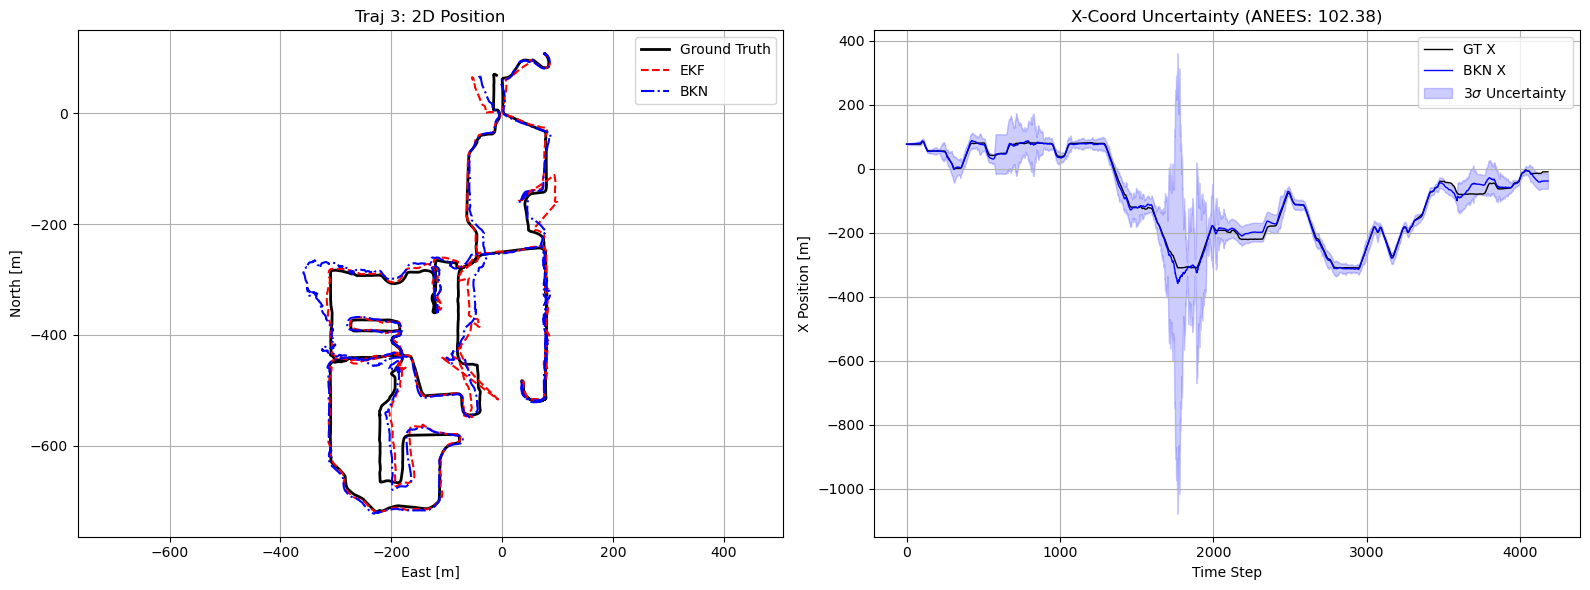


PRŮMĚRNÉ VÝSLEDKY (3 trajektorií)
Metoda     | MSE          | RMSE         | ANEES       
--------------------------------------------------------------------------------
BKN        | 137.27       | 11.72        | 54.16       
EKF        | 264.41       | 16.26        | 594.46      


In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import Filters

# ==============================================================================
# 0. KONFIGURACE A MODEL
# ==============================================================================
DT_SEC = 1.0 
J_SAMPLES = 50  # 50 vzorků pro kvalitní odhad distribuce

if hasattr(sys_model, 'dt'):
    sys_model.dt = DT_SEC
    print(f"INFO: Nastaveno sys_model.dt = {DT_SEC} s")

# Načtení Bayesian modelu
try:
    trained_model_bkn = state_knet
    trained_model_bkn.eval()
    print(f"INFO: Používám Bayesian KalmanNet s J={J_SAMPLES} vzorky.")
except NameError:
    raise NameError("Chyba: 'state_knet' (BKN) neexistuje.")

from Filters import NCLT
# Inicializace klasických filtrů
ukf_filter = NCLT.UnscentedKalmanFilterNCLT(sys_model) 
ekf_filter = NCLT.ExtendedKalmanFilterNCLT(sys_model)

# --- ROBUSTNÍ FUNKCE PRO ANEES ---
def calculate_anees(x_true, x_est, P_est):
    """
    Vypočítá ANEES. Očekává vstupy už se shodnou dimenzí.
    Používá pinv pro stabilitu.
    """
    T = x_true.shape[0]
    anees_list = []
    error = x_true - x_est 

    for t in range(T):
        e_t = error[t].unsqueeze(1) # [n, 1]
        P_t = P_est[t]              # [n, n]
        
        try:
            P_inv = torch.linalg.pinv(P_t, hermitian=True)
        except RuntimeError:
            P_inv = torch.eye(P_t.shape[0], device=P_t.device)
            
        nees = torch.mm(torch.mm(e_t.t(), P_inv), e_t).item()
        anees_list.append(nees)
        
    return np.mean(anees_list)

# ==============================================================================
# 1. EVALUACE A VIZUALIZACE
# ==============================================================================
results = {
    'GPS_Sensor': [],   'GPS_Authors': [],  
    'EKF_MSE': [],      'EKF_ANEES': [],
    'UKF_MSE': [],      'UKF_ANEES': [],
    'BKN_MSE': [],      'BKN_ANEES': []
}

print(f"\nSpouštím detailní evaluaci na {len(test_data_raw)} trajektoriích...")

# HLAVIČKA DETAILNÍ TABULKY
print("\n" + "-"*95)
print(f"{'TRAJEKTORIE':<12} | {'BKN MSE':<10} | {'BKN ANEES':<10} | {'EKF MSE':<10} | {'EKF ANEES':<10} | {'GPS MSE':<10}")
print("-" * 95)

for i, traj in enumerate(test_data_raw):
    # --- PŘÍPRAVA DAT ---
    gt_raw = traj['ground_truth'].float().to(DEVICE)
    gps_filtered = traj['filtered_gps'].float().to(DEVICE)
    gps_filled = traj['gps'].float().to(DEVICE)
    imu_raw = traj['imu'].float().to(DEVICE)
    odo_raw = traj['filtered_wheel'].float().to(DEVICE)
    
    T_len = gt_raw.shape[0]
    
    # Input vector
    u_full = torch.stack((
        torch.nan_to_num(odo_raw[:, 0], nan=0.0),
        torch.nan_to_num(odo_raw[:, 1], nan=0.0),
        imu_raw[:, 2], 
        imu_raw[:, 3]
    ), dim=1).to(DEVICE)
    
    # Init State (bereme z GT)
    # x_true má dimenzi 3 (X, Y, Theta)
    x_true = gt_raw[:, :3] 
    
    # Init pro filtry (plná dimenze modelu)
    m = sys_model.state_dim
    x0_vec = torch.zeros(m).to(DEVICE)
    x0_vec[0] = x_true[0, 0]; x0_vec[1] = x_true[0, 1]
    if m >= 3 and x_true.shape[1] >= 3: x0_vec[4] = x_true[0, 2] 

    # --- A. BĚH BAYESIAN KALMANNET ---
    trained_model_bkn.train() # Nutné pro MC Dropout
    
    batch_x0 = x0_vec.unsqueeze(0).repeat(J_SAMPLES, 1)
    trained_model_bkn.reset(batch_size=J_SAMPLES, initial_state=batch_x0)
    
    bkn_samples = []
    bkn_samples.append(batch_x0.unsqueeze(1))

    with torch.no_grad():
        for t in range(1, T_len):
            y_t = gps_filtered[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            u_t = u_full[t].unsqueeze(0).repeat(J_SAMPLES, 1)
            x_est_j, _ = trained_model_bkn.step(y_t, u_t)
            bkn_samples.append(x_est_j.unsqueeze(1))

    trained_model_bkn.eval() 
    bkn_ensemble = torch.cat(bkn_samples, dim=1) # [J, T, m]
    
    # Statistiky BKN
    x_bkn_mean = torch.mean(bkn_ensemble, dim=0) 
    
    # Výpočet kovariance BKN
    centered = bkn_ensemble - x_bkn_mean.unsqueeze(0)
    centered_perm = centered.permute(1, 2, 0) 
    P_bkn = torch.bmm(centered_perm, centered_perm.transpose(1, 2)) / (J_SAMPLES - 1)
    P_bkn = P_bkn + torch.eye(m, device=DEVICE).unsqueeze(0) * 1e-6 

    # --- B. EKF & UKF ---
    def run_filter(flt):
        try:
            res = flt.process_sequence(gps_filtered, u_seq=u_full, Ex0=x0_vec, P0=sys_model.P0)
            return res['x_filtered'], res.get('P_filtered', torch.eye(m, device=DEVICE).repeat(T_len, 1, 1))
        except:
            return torch.zeros(T_len, m).to(DEVICE), torch.eye(m, device=DEVICE).repeat(T_len, 1, 1)

    x_ekf, P_ekf = run_filter(ekf_filter)
    x_ukf, P_ukf = run_filter(ukf_filter)

    # --- VYHODNOCENÍ (SLICING) ---
    eval_dim = x_true.shape[1] # 3 (X, Y, Theta)

    def evaluate_metrics(est_x, est_P):
        # MSE (poloha X, Y)
        mse = F.mse_loss(est_x[:, :2], x_true[:, :2]).item()
        # ANEES (Oříznuté na eval_dim)
        est_x_sliced = est_x[:, :eval_dim]
        est_P_sliced = est_P[:, :eval_dim, :eval_dim]
        anees = calculate_anees(x_true, est_x_sliced, est_P_sliced)
        return mse, anees

    mse_ekf, anees_ekf = evaluate_metrics(x_ekf, P_ekf)
    mse_ukf, anees_ukf = evaluate_metrics(x_ukf, P_ukf)
    mse_bkn, anees_bkn = evaluate_metrics(x_bkn_mean, P_bkn)
    
    valid_mask = ~torch.isnan(gps_filtered[:, 0])
    mse_gps = F.mse_loss(gps_filtered[valid_mask], x_true[valid_mask, :2]).item() if valid_mask.sum() > 0 else np.nan

    # Ukládání
    results['GPS_Sensor'].append(mse_gps)
    results['EKF_MSE'].append(mse_ekf); results['EKF_ANEES'].append(anees_ekf)
    results['UKF_MSE'].append(mse_ukf); results['UKF_ANEES'].append(anees_ukf)
    results['BKN_MSE'].append(mse_bkn); results['BKN_ANEES'].append(anees_bkn)

    # --- VÝPIS ŘÁDKU TABULKY ---
    print(f"{i+1:<12} | {mse_bkn:<10.2f} | {anees_bkn:<10.2f} | {mse_ekf:<10.2f} | {anees_ekf:<10.2f} | {mse_gps:<10.2f}")

    # --- VIZUALIZACE ---
    gt_np = x_true.cpu().numpy()
    bkn_np = x_bkn_mean.cpu().numpy()
    std_x_bkn = torch.sqrt(P_bkn[:, 0, 0]).cpu().numpy()
    t_axis = np.arange(T_len)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graf 1: 2D Trajektorie
    ax1.plot(gt_np[:, 0], gt_np[:, 1], 'k-', lw=2, label='Ground Truth')
    ax1.plot(x_ekf.cpu().numpy()[:, 0], x_ekf.cpu().numpy()[:, 1], 'r--', lw=1.5, label='EKF')
    ax1.plot(bkn_np[:, 0], bkn_np[:, 1], 'b-.', lw=1.5, label='BKN')
    ax1.set_title(f'Traj {i+1}: 2D Position')
    ax1.set_xlabel('East [m]'); ax1.set_ylabel('North [m]')
    ax1.legend(); ax1.grid(True); ax1.axis('equal')

    # Graf 2: Time Series X s Confidence Tube
    ax2.plot(t_axis, gt_np[:, 0], 'k-', lw=1, label='GT X')
    ax2.plot(t_axis, bkn_np[:, 0], 'b-', lw=1, label='BKN X')
    ax2.fill_between(t_axis, 
                     bkn_np[:, 0] - 3*std_x_bkn, 
                     bkn_np[:, 0] + 3*std_x_bkn, 
                     color='blue', alpha=0.2, label='3$\sigma$ Uncertainty')
    ax2.set_title(f'X-Coord Uncertainty (ANEES: {anees_bkn:.2f})')
    ax2.set_xlabel('Time Step'); ax2.set_ylabel('X Position [m]')
    ax2.legend(); ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 2. FINÁLNÍ SOUHRN
# ==============================================================================
print("\n" + "="*80)
print(f"PRŮMĚRNÉ VÝSLEDKY ({len(test_data_raw)} trajektorií)")
print("="*80)
print(f"{'Metoda':<10} | {'MSE':<12} | {'RMSE':<12} | {'ANEES':<12}")
print("-" * 80)
print(f"{'BKN':<10} | {np.nanmean(results['BKN_MSE']):<12.2f} | {np.sqrt(np.nanmean(results['BKN_MSE'])):<12.2f} | {np.nanmean(results['BKN_ANEES']):<12.2f}")
print(f"{'EKF':<10} | {np.nanmean(results['EKF_MSE']):<12.2f} | {np.sqrt(np.nanmean(results['EKF_MSE'])):<12.2f} | {np.nanmean(results['EKF_ANEES']):<12.2f}")
print("="*80)